<div style="background-image: url('https://images.unsplash.com/photo-1568060179835-109fbff5d403?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60'); background-size: 40%; background-repeat: no-repeat; background-position: right;">

# Shifted Griewank’s Function

$F_5(x) = \sum_{i=1}^{D}\frac{z_i^2}{4000} - \prod_{i=1}^Dcos( \frac {z_i}{\sqrt i}) + 1 + f_{bias_5}$,  $ z = x - o $, $x = [x_1,x_2,...,x_D]$

D: dimensions. $o = [o_1, o_2, ..., o_D]$ : the shifted global optimum.

### Properties:
- Multi-modal
- Shifted
- Non-separable
- Scalable
- Dimension D as 100, 500 and 1000
- $x∈[−600,600]^D$ , Global optimum $x^* = o$ , $F_5(x^*) = f_{bias_5} = -180$
    </div>

In [1]:
import sys
sys.path.append('../') # just to allow using python files at another directory

import numpy as np
from shifted_go import * # shifted global optimum of the functions
from algorithms import * # optimization algorithms customized
from utils import * # functions used to summarise the results

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import pygmo as pg # package with the optimization algorithms
import time
import pandas as pd
from itertools import combinations

## I. Defining the class for the optimization algorithm
<hr>

In [2]:
class shifted_griewank:
    
    def __init__(self, dim):
        self.dim = dim
        self.name = 'shifted Griewank'

    def fitness(self, x):
        z = np.array(x)
        if z.ndim <= 1:
            if np.isscalar(x) == True:
                z = z - griewank[0]
                res = (z**2)/4000 - np.cos(z) + 1
            else:
                z = z - griewank[:len(z)]
                sqroot = np.sqrt(np.arange(1,len(z)+1))
                res = np.sum((z**2)/4000) - np.prod(np.cos(z/sqroot)) + 1
        else:
            z = z - griewank[:z.shape[1]]
            sqroot = np.sqrt(np.arange(1,z.shape[1]+1))
            res = np.sum((z**2)/4000, axis =1) - np.prod(np.cos(z/sqroot), axis =1) + 1
        return [res + f_bias[4]]

    def get_bounds(self):
        return ([-600]*self.dim,[600]*self.dim)
    
    def get_nic(self): # number of inequality constraints
        return 0
    
    def get_nec(self): # number of equality constraints
        return 0
    
    def get_name(self): # number of equality constraints
        return self.name + ' - dimension ' + str(self.dim)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

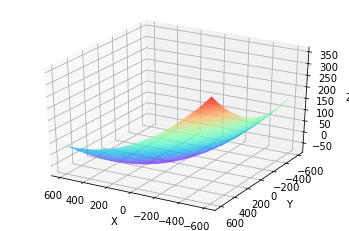

In [3]:
grid = np.array(list(combinations(np.linspace(-600, 600, 100), 2)))
function = shifted_griewank(2)
z = function.fitness(grid)
ax = plt.axes(projection='3d')

ax.plot_trisurf(grid[:,0], grid[:,1], np.array(z).flatten(), cmap='rainbow', linewidth=1)
ax.view_init(30, 120)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Here we highlight that the Griewank has many widespread local minima.

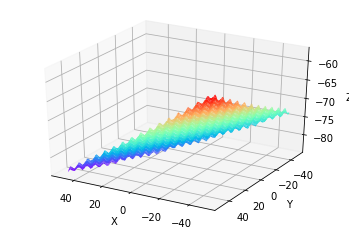

In [4]:
grid = np.array(list(combinations(np.linspace(-50, 50, 100), 2)))
function = shifted_griewank(2)
z = function.fitness(grid)
ax = plt.axes(projection='3d')

ax.plot_trisurf(grid[:,0], grid[:,1], np.array(z).flatten(), cmap='rainbow', linewidth=1)
ax.view_init(30, 120)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# II. Optimizing the function using metaheuristics

<hr>

## II.1 Dimension = 50 

Based on the key point that CMA can improve the performance of non-separable problems and that it is the stateof-the-art in continuous domain evolutionary algorithm we are going to use it on the shifted Griewank optimization.

### Parameters selection

Once PyGMO provides a version of CMA-ES that optimizes the parameters cc, cs, c1, cmu and sigma and it's results are good when compared to manually selection, we are going to use the default values. We are going to evaluate the number of generations and the population size.

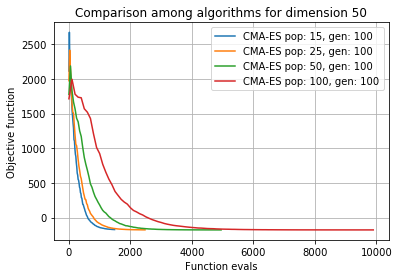

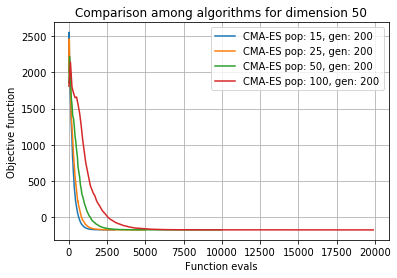

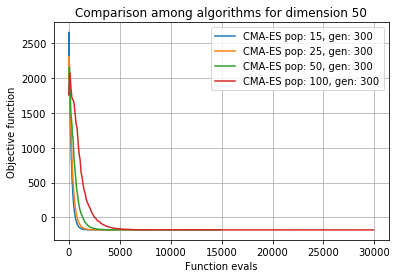

In [5]:
prob = pg.problem(shifted_griewank(50))
stats = []

populations = [15, 25, 50, 100, 15, 25, 50, 100, 15, 25, 50, 100]
generations = [100, 100, 100, 100, 200, 200, 200, 200, 300, 300, 300, 300]
ctr = ''

fig = plt.figure()
for gen, pop_size in zip(generations, populations): 
    logs = []
    best = []
    evals = []
    start_time = time.time()
    for i in range(25):
        algo = pg.algorithm(pg.cmaes(gen=gen, cc=-1, cs=-1, c1=-1, cmu=-1, sigma0=.5, ftol=1e-9, 
            xtol=1e-9, memory=False, force_bounds=True))
        algo.set_verbosity(1) # regulates both screen and log verbosity
        pop = pg.population(prob, pop_size)
        sol = algo.evolve(pop)
        logs.append(algo.extract(pg.cmaes).get_log())
        best.append(sol.champion_f)
        evals.append(sol.problem.get_fevals())
    
    end_time = time.time()
    logs = np.array(logs)
    stats.append(['population: '+ str(pop_size) + ', generations: '+str(gen), (end_time-start_time)/25, np.mean(np.array(evals)), np.max(np.array(best)), 
                    np.min(np.array(best)), np.mean(np.array(best)), np.median(np.array(best))])
    avg_log = np.average(logs,0)
    plt.plot(avg_log[:,1],avg_log[:,2] , label=algo.get_name().split(':')[0] + ' pop: '+ str(pop_size) + ', gen: '+str(gen))
    if ctr == '':
        ctr = gen
    elif pop_size ==100:
        ctr = gen
        plt.title('Comparison among algorithms for dimension ' + str(prob.get_nx()))
        plt.xlabel('Function evals')
        plt.ylabel('Objective function')
        plt.legend() 
        plt.grid() 
        plt.show()

In [6]:
df_stats = pd.DataFrame(stats, columns=['parameters', 'avg computational time (sec)', 'avg function evals' , 
                                        'max', 'min', 'avg', 'median'])
df_stats

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"population: 15, generations: 100",0.382226,1515.0,-172.216790,-176.073909,-174.423835,-174.387589
1,"population: 25, generations: 100",0.633741,2525.0,-177.333619,-178.546122,-178.111019,-178.178361
2,"population: 50, generations: 100",1.194619,5050.0,-178.775198,-178.933114,-178.869247,-178.874535
3,"population: 100, generations: 100",1.958337,10100.0,-178.905785,-178.977139,-178.944409,-178.946735
4,"population: 15, generations: 200",0.822364,3015.0,-179.000292,-179.187777,-179.090997,-179.096620
5,"population: 25, generations: 200",1.132378,5025.0,-179.686766,-179.855694,-179.766341,-179.764851
6,"population: 50, generations: 200",2.143777,10050.0,-179.954111,-179.984740,-179.973924,-179.975153
7,"population: 100, generations: 200",3.956120,20100.0,-179.995070,-179.999046,-179.997474,-179.997567
8,"population: 15, generations: 300",1.330693,4515.0,-179.862707,-179.973872,-179.934482,-179.937335
9,"population: 25, generations: 300",1.735162,7525.0,-179.995243,-179.998891,-179.997463,-179.997392


As we can observe the algorithm converges fast to a point near the optimal solution, but from this point on the convergence to the optimal is really slow. We can see that once we increase the number of generations higher number of individuals do not bring any exceptional improvement to the fitness of the function.

#### a) Fast and Good Accuracy

Below we present the best solution found in a range of 25 runs of the algorithm from a population of 50 individuals with 300 generations, where the number of evaluations considers the total throughout all runs.

Number of function evaluations:  312500.0
Final solution vector:  [ 540.15412081 -322.63495148  128.20903968  -16.82395691  469.55722709
  314.51175252  -52.24180685 -577.79811167  385.68327631  -66.35365772
  138.51944787  350.3231892   506.17089379  285.84636767 -388.48268149
 -113.15893294  522.56654647  500.28983462 -107.6749063   472.37926652
 -530.53383407 -176.55694116  375.79171126 -588.15994983 -433.3384519
 -356.68232626 -361.53959289  124.5473466  -273.37024467 -361.4227534
 -581.66900241  296.14591131  -65.87994923  518.1866432   -40.80708392
  -97.61581507  415.46640457   30.18767573 -356.81555149  206.56791237
  405.73018072 -576.43107602  217.53139662 -144.62820139  398.15471536
    3.37175241  251.36647209  -85.33381739 -234.46168829 -372.41764274]
Fitness:  [-179.9999783]
Wall time: 1min 18s


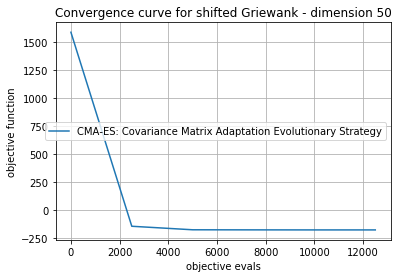

In [7]:
%%time
best = []
fevals = 0
for i in range(25):
    sol = cmaes(shifted_griewank(50), gen=300, cc=- 1, cs=- 1, c1=- 1, cmu=- 1, sigma0=-1, ftol=1e-09, 
            xtol=1e-09, memory=False, force_bounds=True, pop_size = 50)
    if best == [] or sol['champion solution'] < best['champion solution']:
        best = sol    
    fevals += sol['log'][-1][0]

report_convergence(best, fevals)

#### b) Accuraccy

If we decide to privilege accuracy it's necessary to increase the number of generations, and a high number of individuals is not necessary because the CMA works with the distribution for the fitness.

Number of function evaluations:  343750.0
Final solution vector:  [ 540.15513742 -322.63378608  128.21110351  -16.82103303  469.5587503
  314.51621473  -52.23880003 -577.79561166  385.68860971  -66.35597953
  138.51880177  350.32445475  506.17557259  285.84867724 -388.480662
 -113.15253206  522.56365107  500.28533707 -107.67572768  472.37948416
 -530.53044441 -176.55829298  375.79983371 -588.16644003 -433.33096486
 -356.68178756 -361.53388133  124.55102169 -273.37450071 -361.42289743
 -581.67129422  296.14277906  -65.88426677  518.17752302  -40.8067732
  -97.62063896  415.46574879   30.18294659 -356.82316106  206.56494278
  405.74209449 -576.43262247  217.53256369 -144.62274097  398.15525547
    3.37545544  251.36569742  -85.32918619 -234.45918363 -372.41549721]
Fitness:  [-180.]
Wall time: 1min 25s


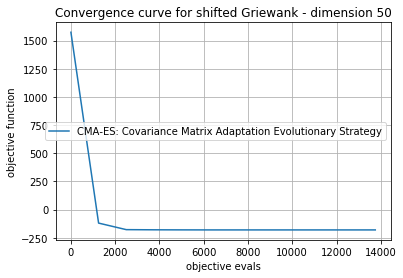

In [8]:
%%time
best = []
fevals = 0
for i in range(25):
    sol = cmaes(shifted_griewank(50), gen=600, cc=-1, cs=-1, c1=-1, cmu=-1, sigma0=-1, ftol=1e-09, 
            xtol=1e-09, memory=False, force_bounds=True, pop_size = 25)
    if best == [] or sol['champion solution'] < best['champion solution']:
        best = sol    
    fevals += sol['log'][-1][0]

report_convergence(best, fevals)

<hr>

## II.2 Dimension = 500

As the function shifted sphere is multimodal and non-separable we are going to choose PSO to explore a great range making the convergence of the swarm fast to the optimal solution.

### Parameters selection


Once we have an multimodal function we are going to set a high social component to privilege particles that find the best solution, whereas the cognitive component will be small. We are going to set a small number to the maximum allowed particle velocity to increase intensification. The inertia will be set to reduce a little bit the current velocity to privilege the other components of velocity.

We have analyzed empirically that the following parameters bring the best results to particle swarm using the package PyGMO:

- <b>variant - 6 </b> Fully Informed (FIPS)
- <b>neighb_type – 2 </b> Ibest swarm topology
- <b>neighb_param – 4 </b> neighbours 

<font color ='blue'>a) Inertia:</font> 0.7

In [9]:
udas = [pg.pso_gen(gen=200, omega= .9, eta1=4, eta2=.5, max_vel = .5, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False), 
        pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .5, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .5, eta1=4, eta2=.5, max_vel = .5, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False)]

df = statistics(shifted_griewank(500), udas, epochs = 25, pop_size = 25)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Generations: 200, Omega: 0.9, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.5, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 2191330987, Verbosity: 1]",1.394200,5025,14336.689635,11812.893524,13573.992226,13707.596993
1,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.5, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 3480170808, Verbosity: 1]",1.656817,5025,5753.833463,4450.828022,5141.511731,5089.037597
2,"[Generations: 200, Omega: 0.5, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.5, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 3717467184, Verbosity: 1]",1.357197,5025,13962.096708,12725.227050,13448.405480,13505.650214


<font color ='blue'>b) Maximum allowed particle velocities: </font> 0.1

In [10]:
udas = [pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False), 
        pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .25, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .5, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = 1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False)]

df = statistics(shifted_griewank(500), udas, epochs = 25, pop_size = 25)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 839038431, Verbosity: 1]",1.458400,5025,4594.567984,3745.321402,4084.036564,4079.173058
1,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.25, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 3860005444, Verbosity: 1]",1.510166,5025,4868.763157,3824.455018,4218.001413,4231.562265
2,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.5, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 2053536108, Verbosity: 1]",1.369715,5025,5680.330351,4421.726008,5012.146737,5017.294697
3,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 3238399636, Verbosity: 1]",1.478463,5025,5792.461557,4560.713048,5218.772436,5207.839678


<font color ='blue'>c) Number of neighbours to consider: </font> 4

In [11]:
udas = [pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 2, memory=False), 
        pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 3, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 5, memory=False)]

df = statistics(shifted_griewank(500), udas, epochs = 25, pop_size = 25)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 2, Memory: false, Seed: 3859758174, Verbosity: 1]",1.626817,5025,5428.840703,4553.626078,5040.539985,5035.620523
1,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 3, Memory: false, Seed: 619752860, Verbosity: 1]",1.275390,5025,5309.105783,4423.354414,4976.241830,4954.332294
2,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 39075978, Verbosity: 1]",1.585741,5025,4302.539436,3609.174222,4045.919843,4101.630343
3,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 5, Memory: false, Seed: 3625817052, Verbosity: 1]",1.469336,5025,4355.340715,3586.318621,4000.136313,3994.755633


<font color ='blue'>d) Social and cognitive influence: </font> 

We see that it's possible to ha good results using two configurations:
- high social and low cognitive component;
- low social and high cognitive component.

In [12]:
udas = [pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=.5, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False), 
        pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=1, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=2, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=3, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=4, eta2=4, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=.5, eta2=4, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False), 
        pg.pso_gen(gen=200, omega= .7, eta1=1, eta2=4, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=2, eta2=4, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=200, omega= .7, eta1=3, eta2=4, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False)]

df = statistics(shifted_griewank(500), udas, epochs = 25, pop_size = 25)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 0.5, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 1566738957, Verbosity: 1]",1.426809,5025,4414.269120,3727.229411,4046.735787,4014.662948
1,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 1, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 2228133690, Verbosity: 1]",1.605560,5025,4118.187614,3230.782536,3647.661651,3584.598303
2,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 2, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 1695650406, Verbosity: 1]",1.639003,5025,3477.830082,2794.280141,3101.291013,3075.020417
3,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 3, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 2706558630, Verbosity: 1]",1.610622,5025,2934.400934,2408.737504,2705.560565,2711.882685
4,"[Generations: 200, Omega: 0.7, Eta1: 4, Eta2: 4, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 2322717116, Verbosity: 1]",1.424227,5025,2717.914856,2036.752961,2418.635993,2412.916383
5,"[Generations: 200, Omega: 0.7, Eta1: 0.5, Eta2: 4, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 4223790196, Verbosity: 1]",1.413819,5025,4706.554947,3591.866970,4033.177781,3970.740173
6,"[Generations: 200, Omega: 0.7, Eta1: 1, Eta2: 4, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 984987121, Verbosity: 1]",1.309990,5025,4349.500541,3324.386764,3728.707204,3754.826904
7,"[Generations: 200, Omega: 0.7, Eta1: 2, Eta2: 4, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 2552130016, Verbosity: 1]",0.972469,5025,3531.540920,2795.809066,3140.130303,3169.110402
8,"[Generations: 200, Omega: 0.7, Eta1: 3, Eta2: 4, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 549794343, Verbosity: 1]",1.327230,5025,3090.622876,2391.869829,2716.581732,2759.113113


<font color ='blue'>e) Number of Generations </font>: 500

In [13]:
udas = [pg.pso_gen(gen=2000, omega= .7, eta1=4, eta2=1, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 2, memory=False), 
        pg.pso_gen(gen=3000, omega= .7, eta1=4, eta2=1, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 3, memory=False),
       pg.pso_gen(gen=4000, omega= .7, eta1=4, eta2=1, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 4, memory=False),
       pg.pso_gen(gen=5000, omega= .7, eta1=4, eta2=1, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 5, memory=False),
       pg.pso_gen(gen=6000, omega= .7, eta1=4, eta2=1, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 5, memory=False)]

df = statistics(shifted_griewank(500), udas, epochs = 1, pop_size = 25)
df

,parameters,avg computational time (sec),avg function evals,max,min,avg,median
0,"[Generations: 2000, Omega: 0.7, Eta1: 4, Eta2: 1, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 2, Memory: false, Seed: 3065987440, Verbosity: 1]",0.531432,50025,148.823351,148.823351,148.823351,148.823351
1,"[Generations: 3000, Omega: 0.7, Eta1: 4, Eta2: 1, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 3, Memory: false, Seed: 415631143, Verbosity: 1]",0.720592,75025,91.905020,91.905020,91.905020,91.905020
2,"[Generations: 4000, Omega: 0.7, Eta1: 4, Eta2: 1, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 4, Memory: false, Seed: 2373315519, Verbosity: 1]",1.174369,100025,-178.729313,-178.729313,-178.729313,-178.729313
3,"[Generations: 5000, Omega: 0.7, Eta1: 4, Eta2: 1, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 5, Memory: false, Seed: 3003942106, Verbosity: 1]",1.350885,125025,-179.458108,-179.458108,-179.458108,-179.458108
4,"[Generations: 6000, Omega: 0.7, Eta1: 4, Eta2: 1, Maximum velocity: 0.1, Variant: 6, Topology: 2, Topology parameter: 5, Memory: false, Seed: 704915535, Verbosity: 1]",1.780175,150025,-179.876342,-179.876342,-179.876342,-179.876342


After analyzing the statistics of the different parameters we decide for the following configuration:

- gen = 6000
- omega = .7
- eta1 = 4
- eta2 = 1
- max_vel = .1
- variant = 6
- neighb_type = 2
- neighb_param = 4
- memory = False
- pop_size = 25

Number of function evaluations:  3719375.0
Final solution vector:  [ 540.13926231 -322.64964306  128.16314927  -16.83533907  469.57462635
  314.49622666  -52.21934541 -577.77780957  385.74280886  -66.37434065
  138.59268096  350.3327906   506.22489047  285.76665779 -388.49304682
 -113.13920027  522.64106831  500.30637507 -107.60421299  472.265478
 -530.46717212 -176.90097354  375.81032845 -588.00876977 -434.31231626
 -356.74656877 -361.53092946  124.6320833  -273.41898616 -357.59417332
 -581.70443557  296.0711494   -65.8301467   518.11522241  -40.641793
  -97.60427762  415.4402918    30.3589603  -356.7366434   206.63198502
  405.66337612 -576.26704724  217.40822152 -144.61519043  395.57095197
    3.59178614  251.4096972   -85.31835546 -234.37281188 -371.71330977
 -367.85636977  218.71165679 -236.70140136   50.10575584 -417.78398502
  237.32523009 -146.0775189   432.0946531   424.38393155  112.32133933
   -4.0917544   479.75723279  385.80898317  174.12210178  381.51984841
  192.51604903

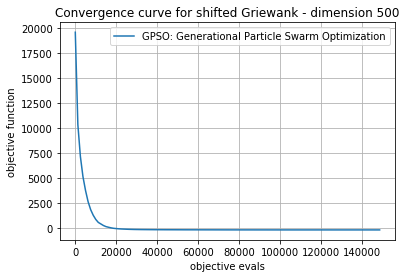

In [16]:
%%time
best = []
fevals = 0
for i in range(25):
    sol = pso(shifted_griewank(500), gen=6000, omega= .7, eta1=4, eta2=.5, max_vel = .1, variant = 6, neighb_type = 2, 
              neighb_param = 5, memory=False, pop_size = 25)
    if best == [] or sol['champion solution'] < best['champion solution']:
        best = sol    
    fevals += sol['log'][-1][0]

report_convergence(best, fevals)